In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.metrics import cohen_kappa_score

from skimage.measure import label as skimage_label
import matplotlib.pyplot as plt
import scipy.io as sio
from tqdm import tqdm
import pandas as pd

In [2]:
# Set device
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
import requests
from pathlib import Path
def download_dataset(name='indian_pines'):
        """
        Download Indian Pines dataset if not already present
        """
        # Creating data directory if it doesn't exist
        Path('data').mkdir(exist_ok=True)
        
        # URLs for the dataset
        if name == 'indian_pines':
            data_url = "http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat"
            labels_url = "http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat"
            
            # Downloading data files if they don't exist
            for url, filename in [(data_url, 'indian_pines_corrected.mat'), 
                                (labels_url, 'indian_pines_gt.mat')]:
                file_path = Path('data') / filename
                if not file_path.exists():
                    print(f"Downloading {filename}...")
                    response = requests.get(url)
                    with open(file_path, 'wb') as f:
                        f.write(response.content)
                    print(f"Downloaded {filename}")
            
        if name == 'pavia':
            data_url = "https://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat"
            labels_url = "https://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat"
            
            # Downloading data files if they don't exist
            for url, filename in [(data_url, 'PaviaU.mat'), 
                                (labels_url, 'PaviaU_gt.mat')]:
                file_path = Path('data') / filename
                if not file_path.exists():
                    print(f"Downloading {filename}...")
                    response = requests.get(url)
                    with open(file_path, 'wb') as f:
                        f.write(response.content)
                    print(f"Downloaded {filename}")

        
def load_dataset(name='indian_pines'):
        """
        Load Indian Pines dataset
        """
        # Download dataset if not already present
        download_dataset(name)
        
        # Load the data and labels
        if name == 'indian_pines':
            data_path = Path('data') / 'indian_pines_corrected.mat'
            labels_path = Path('data') / 'indian_pines_gt.mat'
            
            data = sio.loadmat(data_path)['indian_pines_corrected']
            labels = sio.loadmat(labels_path)['indian_pines_gt']

            label_names = [
                'Background',
                'Alfalfa',
                'Corn-notill',
                'Corn-mintill',
                'Corn',
                'Grass-pasture',
                'Grass-trees',
                'Grass-pasture-mowed',
                'Hay-windrowed',
                'Oats',
                'Soybean-notill',
                'Soybean-mintill',
                'Soybean-clean',
                'Wheat',
                'Woods',
                'Buildings-Grass-Trees-Drives',
                'Stone-Steel-Towers'
            ]

        if name == 'pavia':
            data_path = Path('data') / 'PaviaU.mat'
            labels_path = Path('data') / 'PaviaU_gt.mat'
            
            data = sio.loadmat(data_path)['paviaU']
            labels = sio.loadmat(labels_path)['paviaU_gt']

            label_names = [
                'Background',
                'Asphalt',
                'Meadows',
                'Gravel',
                'Trees',
                'Painted metal sheets',
                'Bare soil',
                'Bitumen',
                'Self-blocking bricks',
                'Shadows'
            ]
        
        return data, labels, label_names

In [4]:
def count_classes(hsi_data, ground_truth, label_names):
    """
    Count the number of classes in the dataset and plot the distribution of classes.
    """
    # Flatten the ground truth array to count unique classes
    flat_gt = ground_truth.flatten()
    
    # Count unique classes
    unique_classes, counts = np.unique(flat_gt, return_counts=True)
    
    # Create a dictionary for class counts
    class_counts = {label_names[i]: counts[i] for i in range(len(unique_classes))}
    
    print("Class counts:")
    for label, count in class_counts.items():
        print(f"{label}: {count}")
        
    # Plot the class distribution
    plt.figure(figsize=(10, 5))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xticks(rotation=45)
    plt.xlabel('Classes')
    plt.ylabel('Number of Pixels')
    plt.title('Class Distribution')
    plt.show()

def plot_ground_truth(hsi_data, ground_truth, label_names):
    """
    Plot the ground truth labels.
    """
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(np.mean(hsi_data, axis=2), cmap='gray')
    plt.title('Hyperspectral Image')
    plt.colorbar(label='Intensity')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(ground_truth, cmap='tab20')
    plt.colorbar(ticks=range(len(label_names)), label='Classes')
    plt.title('Ground Truth')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Data shape: (145, 145, 200)
Class counts:
Background: 10776
Alfalfa: 46
Corn-notill: 1428
Corn-mintill: 830
Corn: 237
Grass-pasture: 483
Grass-trees: 730
Grass-pasture-mowed: 28
Hay-windrowed: 478
Oats: 20
Soybean-notill: 972
Soybean-mintill: 2455
Soybean-clean: 593
Wheat: 205
Woods: 1265
Buildings-Grass-Trees-Drives: 386
Stone-Steel-Towers: 93


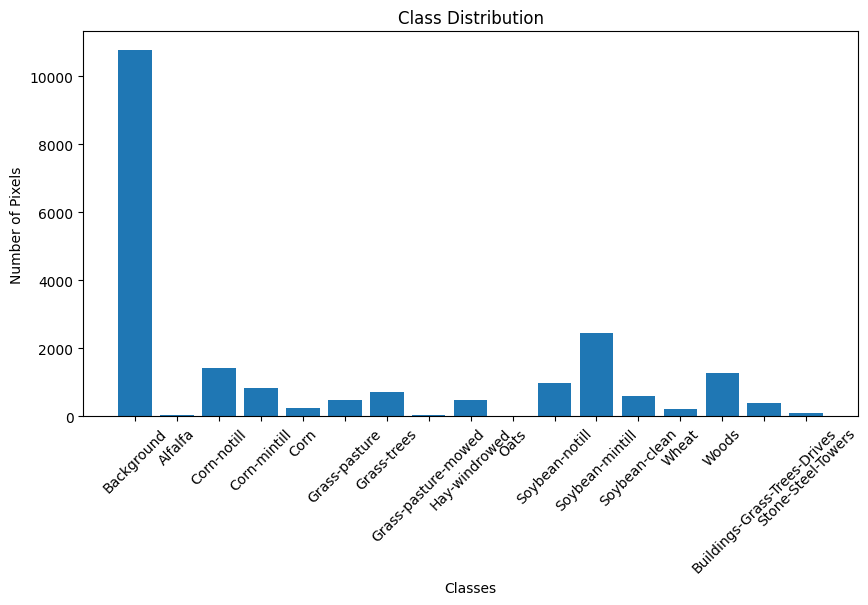

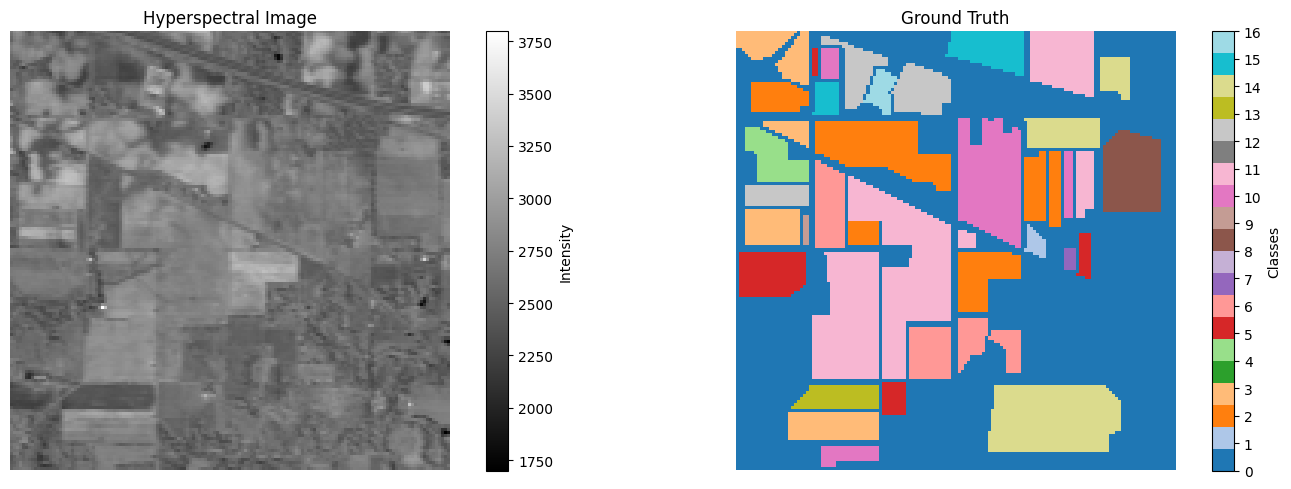

In [5]:
hsi_data, ground_truth, label_names = load_dataset('indian_pines')
print(f"Data shape: {hsi_data.shape}")
count_classes(hsi_data, ground_truth, label_names)
plot_ground_truth(hsi_data, ground_truth, label_names)

Data shape: (610, 340, 103)
Class counts:
Background: 164624
Asphalt: 6631
Meadows: 18649
Gravel: 2099
Trees: 3064
Painted metal sheets: 1345
Bare soil: 5029
Bitumen: 1330
Self-blocking bricks: 3682
Shadows: 947


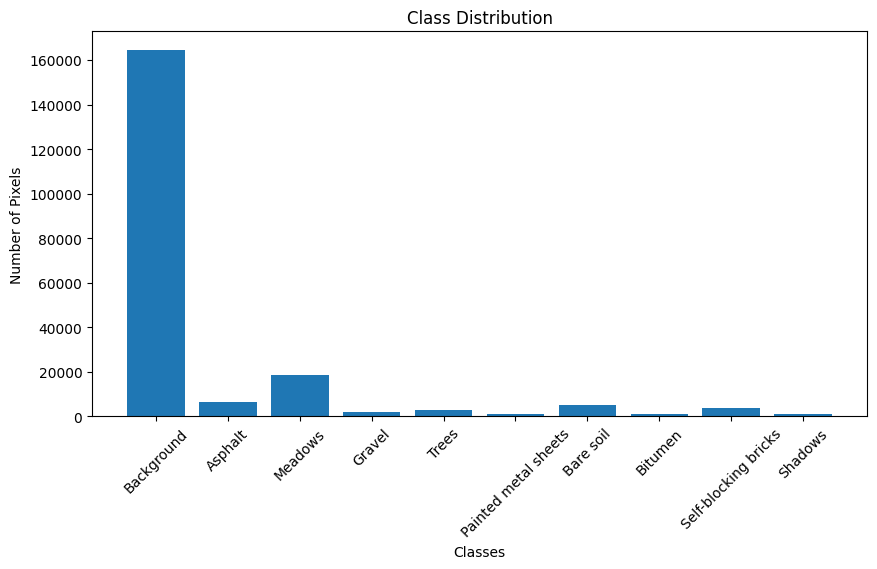

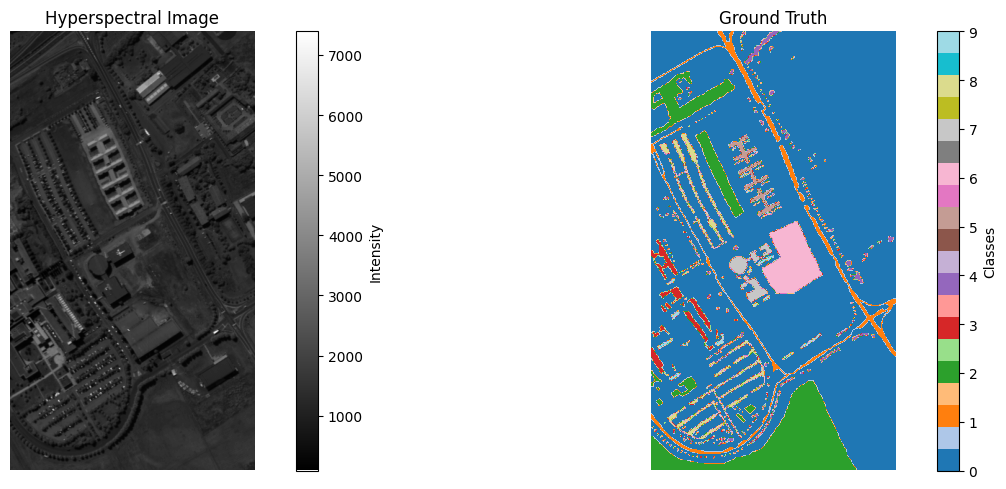

In [6]:
hsi_data, ground_truth, label_names = load_dataset('pavia')
print(f"Data shape: {hsi_data.shape}")
count_classes(hsi_data, ground_truth, label_names)
plot_ground_truth(hsi_data, ground_truth, label_names)

In [7]:
def apply_pca(data, n_components=50):
    """
    Apply PCA to reduce the dimensionality of hyperspectral data
    
    Parameters:
    -----------
    data : numpy.ndarray
        Hyperspectral data of shape (H, W, D)
    n_components : int
        Number of principal components to keep
        
    Returns:
    --------
    numpy.ndarray
        Reduced data of shape (H, W, n_components)
    """
    h, w, d = data.shape
    data_reshaped = data.reshape(-1, d)
    
    # Initialize and fit PCA
    print(f"Applying PCA to reduce dimensions from {d} to {n_components}...")
    pca = PCA(n_components=n_components, whiten=True)
    data_reduced = pca.fit_transform(data_reshaped)
    
    # Reshape back to original spatial dimensions
    data_reduced = data_reduced.reshape(h, w, n_components)
    
    return data_reduced

def plot_reduced_data(data, title):
    """
    Plot the first two components of the reduced data.
    """
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(data[:, :, 0], cmap='gray')
    plt.title(f'{title} - Component 1')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(data[:, :, 1], cmap='gray')
    plt.title(f'{title} - Component 2')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [8]:
class HSIDataset(Dataset):
    """Dataset class for Hyperspectral Image data"""
    def __init__(self, data, labels=None, patch_size=7):
        self.data = data
        self.labels = labels
        self.patch_size = patch_size
        self.h, self.w, self.bands = data.shape
        self.pad_size = patch_size // 2
        
        # Pad the data to handle boundary patches
        self.padded_data = np.pad(
            data, 
            ((self.pad_size, self.pad_size), 
             (self.pad_size, self.pad_size), 
             (0, 0)), 
            mode='reflect'
        )
        
    def __len__(self):
        if self.labels is not None:
            return np.sum(self.labels > 0)  # Skip background class (0)
        else:
            return self.h * self.w
    
    def __getitem__(self, idx):
        if self.labels is not None:
            # For labeled data, convert flat index to position where label > 0
            positions = np.where(self.labels > 0)
            i, j = positions[0][idx], positions[1][idx]
            label = self.labels[i, j] - 1  # Adjust class labels to start from 0
        else:
            # For unlabeled data
            i, j = idx // self.w, idx % self.w
            label = -1  # -1 indicates unlabeled
        
        # Extract patch
        i_padded, j_padded = i + self.pad_size, j + self.pad_size
        patch = self.padded_data[
            i_padded-self.pad_size:i_padded+self.pad_size+1,
            j_padded-self.pad_size:j_padded+self.pad_size+1,
            :
        ]
        
        # Convert to tensor
        patch = torch.from_numpy(patch).float()
        # Reshape to [C, H, W] format for CNN
        patch = patch.permute(2, 0, 1)
        label = torch.tensor(label).long()

        positions = torch.tensor([i, j]).int()
    
        return patch, label, positions

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def compute_output_dim(input_dim, kernel_size, padding=0, stride=1, dilation=1):
    return ((input_dim + 2 * padding - dilation * (kernel_size - 1) - 1) // stride) + 1


class Conv3DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm3d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)


class Conv2DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)


class MultiscaleInceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels_per_scale, scales):
        """
        Multiscale inception-style feature extraction block
        
        Args:
            in_channels: Number of input channels
            out_channels_per_scale: Number of output channels per scale branch
            scales: List of kernel sizes for each scale [(d1,h1,w1), (d2,h2,w2), ...]
        """
        super().__init__()
        
        self.branches = nn.ModuleList()
        self.num_scales = len(scales)
        
        # Create a branch for each scale
        for kernel_size in scales:
            # Calculate appropriate padding to maintain spatial dimensions
            d_pad, h_pad, w_pad = kernel_size[0]//2, kernel_size[1]//2, kernel_size[2]//2
            
            branch = Conv3DBlock(
                in_channels=in_channels,
                out_channels=out_channels_per_scale,
                kernel_size=kernel_size,
                padding=(d_pad, h_pad, w_pad)
            )
            self.branches.append(branch)
            
        # 1x1x1 convolution to reduce channel dimension after concatenation
        total_channels = out_channels_per_scale * len(scales)
        self.channel_reducer = nn.Conv3d(total_channels, out_channels_per_scale * 2, kernel_size=1)
        self.bn = nn.BatchNorm3d(out_channels_per_scale * 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Process input through each scale branch
        branch_outputs = [branch(x) for branch in self.branches]
        
        # Concatenate along channel dimension
        x = torch.cat(branch_outputs, dim=1)
        
        # Apply channel reduction
        x = self.channel_reducer(x)
        x = self.bn(x)
        x = self.relu(x)
        
        return x


class TransformerBlock(nn.Module):
    def __init__(self, embedding_dim, mlp_dim, num_heads):
        super().__init__()
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.attn = nn.MultiheadAttention(embedding_dim, num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embedding_dim),
        )

    def forward(self, x):
        residual = x
        x = self.norm1(x)
        x, _ = self.attn(x, x, x)
        x = residual + x
        residual = x
        x = self.norm2(x)
        x = self.mlp(x)
        return residual + x


class HybridHSIClassifier(nn.Module):
    def __init__(self, input_channels=50, num_classes=16, embedding_dim=64, patch_size=13,
                 noise=None, noise_scale=0.1, num_heads=8, mlp_dim=128, padding=1, num_tokens=4):
        super().__init__()
        self.noise = noise
        self.noise_scale = noise_scale
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.num_tokens = num_tokens
        
        # Define multiscale kernels
        self.scales = [
            (3, 1, 1),  # Scale 1: Small kernel for fine details
            (3, 3, 3),  # Scale 2: Medium kernel for local features
            (5, 5, 5),  # Scale 3: Large kernel for broader context
            (7, 3, 3),  # Scale 4: Medium kernel but elongated for spectral features
            (3, 3, 7),  # Scale 5
            (3, 7, 3),  # Scale 5
        ]
        
        # Output channels per scale branch
        out_channels_per_scale = 16
        
        # Replace single Conv3D with MultiscaleInceptionBlock
        self.multiscale_extractor = MultiscaleInceptionBlock(
            in_channels=1,
            out_channels_per_scale=out_channels_per_scale,
            scales=self.scales
        )
        
        # Calculate output dimensions after multiscale extraction
        # Using Scale 2 (medium) as reference for dimension calculation
        reference_scale = self.scales[1]
        self.conv3d_dout = compute_output_dim(input_channels, reference_scale[0], padding=reference_scale[0]//2)
        self.conv3d_hout = compute_output_dim(patch_size, reference_scale[1], padding=reference_scale[1]//2)
        self.conv3d_wout = compute_output_dim(patch_size, reference_scale[2], padding=reference_scale[2]//2)
        
        # Secondary feature refinement using 2D convolution
        # Input channels = multiscale output channels * depth dimension
        multiscale_out_channels = out_channels_per_scale * 2  # from channel reducer
        self.conv2d = Conv2DBlock(
            multiscale_out_channels * self.conv3d_dout, 
            64, 
            kernel_size=(3, 3), 
            padding=1
        )
        
        self.conv2d_hout = self.conv3d_hout  # Same due to proper padding
        self.conv2d_wout = self.conv3d_wout  # Same due to proper padding
        
        self.spatial_features = self.conv2d_hout * self.conv2d_wout
        
        # Class token
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))
        
        # Position embedding for all tokens (including CLS)
        self.pos_embedding = nn.Parameter(torch.empty(1, (self.spatial_features + 1), embedding_dim))
        torch.nn.init.normal_(self.pos_embedding, std=.02)
        
        # Transformer block
        self.transformer = TransformerBlock(embedding_dim, mlp_dim, num_heads)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.GELU(),
            nn.Linear(128, num_classes)
        )

    def apply_noise(self, x):
        if self.noise == 'Gaussian':
            noise = torch.randn_like(x) * x.std() * self.noise_scale
            x = x + noise
        elif self.noise == 'Poisson':
            noise = torch.poisson(x * self.noise_scale)
            x = x + noise
        elif self.noise == 'SaltPepper':
            mask = torch.rand_like(x)
            x = torch.where(mask < 0.05, x.min(), x)
            x = torch.where(mask > 0.95, x.max(), x)
        elif self.noise == 'Speckle':
            noise = torch.randn_like(x) * self.noise_scale * x
            x = x + noise
        return x

    def forward(self, x):
        B = x.size(0)
        
        # Multiscale 3D feature extraction
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.multiscale_extractor(x)
        
        # Reshape for 2D convolution
        x = x.view(B, -1, self.conv3d_hout, self.conv3d_wout)
        x = self.conv2d(x)
        
        # Apply noise if in training mode
        if self.training and self.noise:
            x = self.apply_noise(x)
        
        # Reshape for transformer: [B, C, H*W] -> [B, H*W, C]
        tokens = x.view(B, 64, -1).transpose(1, 2)
        
        # Add class token
        cls_token = self.cls_token.expand(B, -1, -1)  # [B, 1, embedding_dim]
        x = torch.cat([cls_token, tokens], dim=1)  # [B, 1+spatial_features, embedding_dim]
        
        # Add positional embedding
        x = x + self.pos_embedding
        
        # Apply transformer
        x = self.transformer(x)
        
        # Extract class token for classification
        cls_token_out = x[:, 0]
        
        # Apply classifier
        return self.classifier(cls_token_out)

## SSL part

In [10]:
class ProgressivePseudoLabelSelection:
    """Implementation of the Progressive Pseudo-Label Selection algorithm"""
    def __init__(self, model, device, num_classes, confidence_threshold=0.9, region_threshold=100):
        self.model = model
        self.device = device
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.region_threshold = region_threshold
        self.current_round = 0
        self.prev_confidence_map = None
        self.current_confidence_map = None
        self.current_round = 1

    def train_model(self, train_loader, optimizer, criterion, epochs=5, verbose=True):
        """Train the model with current labeled data"""
        self.model.train()
        for epoch in range(epochs):
            running_loss = 0.0
            correct = 0
            total = 0
            
            if verbose == "Full no":
                loop = tqdm(train_loader, leave=False)
            else:
                loop = tqdm(train_loader, leave=verbose)
            for inputs, labels, _ in loop:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                loop.set_description(f'Epoch {epoch+1}/{epochs}')
                loop.set_postfix(loss=running_loss/len(train_loader), acc=100.*correct/total)
            
    def generate_prediction_maps(self, dataset, image_shape):
        """Generate confidence and label maps for the entire HSI"""
        self.model.eval()
        dataloader = DataLoader(dataset, batch_size=128, shuffle=False)
        
        h, w = image_shape
        confidence_map = np.zeros((h, w))
        label_map = np.zeros((h, w), dtype=int)
        
        with torch.no_grad():
            #loop = tqdm(dataloader)
            for inputs, _, positions in dataloader:
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                probabilities = torch.softmax(outputs, dim=1)
                
                confidence_values, predicted_labels = probabilities.max(1)
                
                for idx, (i, j) in enumerate(positions):
                    confidence_map[i.item(), j.item()] = confidence_values[idx].item()
                    label_map[i.item(), j.item()] = predicted_labels[idx].item()
                
        # Store current confidence map for active learning
        if self.current_confidence_map is None:
            self.current_confidence_map = confidence_map.copy()
        else:
            self.prev_confidence_map = self.current_confidence_map.copy()
            self.current_confidence_map = confidence_map.copy()

        return confidence_map, label_map
    
    def select_pseudo_labels(self, confidence_map, label_map, few_shot_positions, unlabeled_mask, ground_truth):
        """Select reliable pseudo-labels using spatial-spectral consistency"""
        # Apply confidence threshold
        thresholded_map = np.zeros_like(confidence_map)
        thresholded_map[confidence_map > self.confidence_threshold] = 1
        
        # Find connected regions in label map where confidence is high
        masked_labels = label_map.copy()
        masked_labels[thresholded_map == 0] = -1  # Mark low confidence regions as -1
        masked_labels[ground_truth == 0] = -1  # Mark unlabeled regions as -1

        # Find connected regions (8-neighborhood)
        labeled_regions, num_regions = skimage_label(masked_labels, connectivity=2, background=-1, return_num=True)
        
        # Initialize mask for selected pseudo-labels
        selected_mask = np.zeros_like(confidence_map, dtype=bool)
        
        # Identify regions containing few-shot samples
        fs_regions = set()
        for i, j in few_shot_positions:
            region_id = labeled_regions[i, j]
            if region_id > 0: # Exclude background
                fs_regions.add(region_id)
        
        # Select all pixels in regions containing few-shot samples
        for region_id in fs_regions:
            selected_mask[labeled_regions == region_id] = True
        
        # Filter by unlabeled mask (to avoid selecting already labeled samples)
        selected_mask = selected_mask & unlabeled_mask
        
        # Regions for active learning (don't contain FS samples but have high confidence)
        remaining_regions = {}
        for region_id in range(1, num_regions + 1):
            if region_id not in fs_regions:
                region_size = np.sum(labeled_regions == region_id)
                if region_size > self.region_threshold:
                    remaining_regions[region_id] = {
                        'size': region_size,
                        'positions': np.where(labeled_regions == region_id)
                    }
        
        return selected_mask, labeled_regions, remaining_regions
    
    def active_learning_selection(self, confidence_map, label_map, labeled_regions, remaining_regions, ground_truth, max_queries=5):
        """Select most informative samples for expert annotation using active learning"""
        selected_positions = []
        
        selected_regions = []
        
        # Sort regions by size (prioritize larger regions)
        sorted_regions = sorted(remaining_regions.items(), key=lambda x: x[1]['size'], reverse=True)
        
        queries_used = 0
        for region_id, region_info in sorted_regions:
            if queries_used >= max_queries:
                break
                
            # Get positions and confidence values for this region
            positions = list(zip(region_info['positions'][0], region_info['positions'][1]))
            # Check only valid positions (not already in training set) and not background
            positions = [(i, j) for i, j in positions if confidence_map[i, j] > self.confidence_threshold and ground_truth[i, j] > 0]
            if len(positions) == 0:
                continue
            
            region_confidence = [confidence_map[i, j] for i, j in positions]
            
            # Get bottom n confident samples (n=min(5, region_size))
            n = min(5, len(positions))
            bottom_indices = np.argsort(region_confidence)[:n]
            bottom_positions = [positions[i] for i in bottom_indices]
            
            # If we have previous confidence map, compute difference
            if self.prev_confidence_map is not None:
                # Compute confidence change for bottom samples
                confidence_diff = [abs(confidence_map[i, j] - self.prev_confidence_map[i, j]) for i, j in bottom_positions]
                # Select sample with maximum difference
                max_diff_idx = np.argmax(confidence_diff)
                selected_pos = bottom_positions[max_diff_idx]
            else:
                # Just select the least confident sample
                selected_pos = bottom_positions[0]
            
            # Get predicted label and "expert" label (ground truth)
            i, j = selected_pos
            predicted_label = label_map[i, j]
            expert_label = ground_truth[i, j] - 1  # Adjust to 0-based indexing
            
            # Add position for expert annotation
            selected_positions.append((i, j, expert_label))
            
            # If prediction matches expert, add whole region
            if predicted_label == expert_label:
                selected_regions.append(region_id)
           # else:
                # Otherwise, add only the selected position (handled in update_training_set with expert_positions)
            
            queries_used += 1
        
       # if queries_used > 0:
        #    print(f"Selected {queries_used} positions for expert annotation.")
            
        if self.current_round % 2 == 0:
            self.region_threshold = self.region_threshold//2  # Decrease threshold for next round

        self.current_round += 1

        return selected_positions, selected_regions
    
    def update_training_set(self, labeled_mask, selected_mask, labeled_regions, selected_regions, expert_positions):
        """Update the training set with new pseudo-labels and expert annotations"""
        new_labeled_mask = labeled_mask.copy()
        
        # Add pseudo-labeled samples
        new_labeled_mask = new_labeled_mask | selected_mask
        
        # Add samples from selected regions (active learning)
        for region_id in selected_regions:
            new_labeled_mask[labeled_regions == region_id] = True
        
        # Add expert annotated samples
        for i, j, _ in expert_positions:
            new_labeled_mask[i, j] = True
        
        return new_labeled_mask
    
    def evaluate(self, test_loader):
        """Evaluate the model on test data"""
        self.model.eval()
        all_preds = []
        all_labels = []
        all_positions = []
        
        with torch.no_grad():
            for inputs, labels, positions in test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = outputs.max(1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_positions.extend(positions)
        
        # Only evaluate on labeled pixels (gt > 0)
        valid_indices = [i for i, label in enumerate(all_labels) if label >= 0]
        valid_preds = [all_preds[i] for i in valid_indices]
        valid_labels = [all_labels[i] for i in valid_indices]
        
        accuracy = accuracy_score(valid_labels, valid_preds)
        conf_matrix = confusion_matrix(valid_labels, valid_preds)
        kappa = cohen_kappa_score(valid_labels, valid_preds)
        
        return accuracy, kappa, conf_matrix, valid_preds, valid_labels, all_positions

In [11]:
def create_few_shot_samples(ground_truth, k_shots=5):
    """
    Create few-shot training samples by selecting k samples per class
    
    Parameters:
    -----------
    ground_truth : numpy.ndarray
        Ground truth labels of shape (H, W)
    k_shots : int
        Number of samples per class
        
    Returns:
    --------
    list
        List of (i, j) coordinates for few-shot labeled samples
    """
    few_shot_indices = []
    classes = np.unique(ground_truth)
    
    # Skip background class (0)
    classes = classes[classes > 0]
    
    for c in classes:
        class_indices = np.where(ground_truth == c)
        # Ensure we have enough samples for this class
        if len(class_indices[0]) >= k_shots:
            # Randomly select k samples
            selected_indices = np.random.choice(len(class_indices[0]), k_shots, replace=False)
            for idx in selected_indices:
                few_shot_indices.append((class_indices[0][idx], class_indices[1][idx]))
        else:
            # If less than k samples, take all available
            for idx in range(len(class_indices[0])):
                few_shot_indices.append((class_indices[0][idx], class_indices[1][idx]))
    
    return few_shot_indices

Few-shot samples: 80 selected


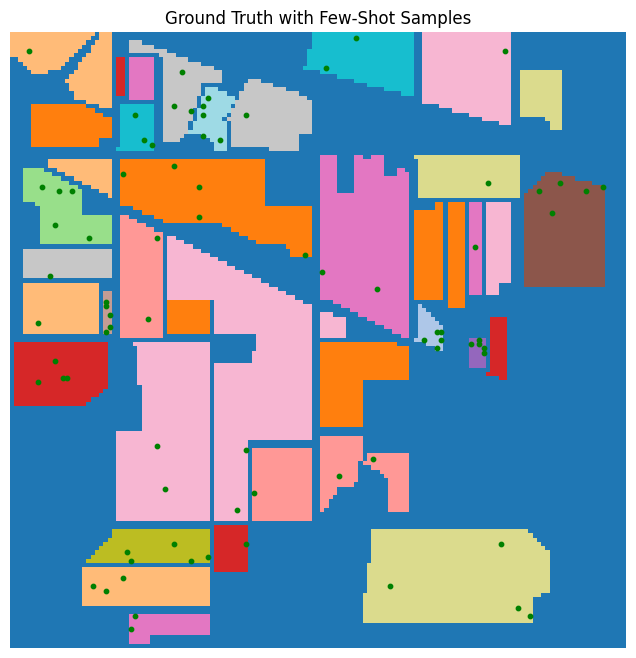

In [12]:
# Test few-shot sample creation
hsi_data, ground_truth, label_names = load_dataset('indian_pines')
few_shot_samples = create_few_shot_samples(ground_truth, k_shots=5)
print(f"Few-shot samples: {len(few_shot_samples)} selected")

plt.figure(figsize=(8, 8))
plt.imshow(ground_truth, cmap='tab20')
plt.title('Ground Truth with Few-Shot Samples')
for i, j in few_shot_samples:
    plt.scatter(j, i, color='green', s=10)
plt.axis('off')
plt.show()

In [13]:
def train_with_progressive_selection(hsi_data, ground_truth, few_shot_indices, 
                                    num_classes, epochs, max_rounds=8, confidence_threshold=0.7, patch_size=7, embedding_dim=64, padding=0,
                                    region_threshold=100,
                                    noise=None,
                                    verbose=True,
                                    device='cuda'):
    """
    Main function to train HSI classifier with progressive pseudo-label selection
    
    Parameters:
    -----------
    hsi_data : numpy.ndarray
        Hyperspectral image data of shape (H, W, D) where D is the number of spectral bands
    ground_truth : numpy.ndarray
        Ground truth labels of shape (H, W)
    few_shot_indices : list of tuples
        List of (i, j) coordinates for few-shot labeled samples
    num_classes : int
        Number of classes in the dataset
    max_rounds : int
        Maximum number of training rounds
    confidence_threshold : float
        Threshold for selecting reliable pseudo-labels
    device : str
        Device to use for training ('cuda' or 'cpu')
    """
    h, w, d = hsi_data.shape
    
    # Create initial labeled mask
    labeled_mask = np.zeros((h, w), dtype=bool)
    for i, j in few_shot_indices:
        labeled_mask[i, j] = True
    
    # Initialize model
    model = HybridHSIClassifier(
        input_channels=30, num_classes=num_classes, embedding_dim=embedding_dim, patch_size=patch_size,
        num_heads=8, mlp_dim=16, padding=padding, num_tokens=8, noise=noise
    )
    model = model.to(device)
    
    # Initialize optimizer and loss function
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    # Initialize progressive selection
    ps = ProgressivePseudoLabelSelection(
        model=model,
        device=device,
        num_classes=num_classes,
        confidence_threshold=confidence_threshold,
        region_threshold=region_threshold
    )
    
    # Store accuracy and errors for each round
    round_accuracies = {'all': [], 'valid': [], 'class': []}
    round_kappas = {'all': [], 'valid': []}
    pseudo_label_errors = []
    
    # Create dataset for unlabeled samples
    full_dataset = HSIDataset(data=hsi_data, patch_size=patch_size)
    
    # Create dataset for all valid pixels (gt > 0) for evaluation
    valid_pixels_dataset = HSIDataset(data=hsi_data, labels=ground_truth, patch_size=patch_size)
    
    trainig_gt = ground_truth.copy()
    trainig_gt[~labeled_mask] = 0
    training_valid_pixels_dataset = HSIDataset(data=hsi_data, labels=trainig_gt, patch_size=patch_size)

    # Precompute mapping from (i, j) coordinate to valid_pixels_dataset index
    valid_positions_coords = list(zip(*np.where(ground_truth > 0))) # List of (i,j) tuples for valid pixels
    coord_to_valid_pixels_idx = {coord: idx for idx, coord in enumerate(valid_positions_coords)} # Map (i,j) -> index in valid_pixels_dataset

    for round_idx in range(max_rounds):
        if verbose!="Full no":
            print(f"\n===== Round {round_idx+1}/{max_rounds} =====")

        # Create dataset for current labeled samples
        # Get the (i, j) coordinates of pixels that are currently labeled AND are not background
        labeled_indices_coords = list(zip(*np.where(training_valid_pixels_dataset.labels > 0)))

        # Map these coordinates to their relative indices within valid_pixels_dataset
        train_coord_to_valid_pixels_idx = {coord: idx for idx, coord in enumerate(labeled_indices_coords)} # Map (i,j) -> index in valid_pixels_dataset
        train_indices_relative = [train_coord_to_valid_pixels_idx[coord] for coord in labeled_indices_coords if coord in train_coord_to_valid_pixels_idx]

        # Print the number of training samples for this round
        if verbose!="Full no":
            print(f"Number of training samples for round {round_idx+1}: {len(train_indices_relative)}") # Added print statement

        if len(train_indices_relative) > 0:
            # Create training dataloader using the relative indices
            train_loader = DataLoader(
                torch.utils.data.Subset(training_valid_pixels_dataset, train_indices_relative), # Use the new relative indices
                batch_size=32,
                shuffle=True,
            )
            # Train model
            ps.train_model(train_loader, optimizer, criterion, epochs=epochs, verbose=verbose)
        else:
            if verbose!="Full no":
                  print("No labeled samples for training in this round.")

        # Generate confidence and label maps
        confidence_map, label_map = ps.generate_prediction_maps(full_dataset, (h, w))

        # Select reliable pseudo-labels
        unlabeled_mask = ~labeled_mask & (ground_truth > 0)  # Only consider valid pixels
        selected_mask, labeled_regions, remaining_regions = ps.select_pseudo_labels(
            confidence_map, label_map, few_shot_indices, unlabeled_mask, ground_truth
        )

        # Compute error rate of pseudo-labels (for evaluation)
        if np.sum(selected_mask) > 0:
            pseudo_labels = label_map[selected_mask]
            true_labels = ground_truth[selected_mask] - 1  # Adjust to 0-based indexing
            error_rate = np.mean(pseudo_labels != true_labels)
            pseudo_label_errors.append(error_rate)
            if verbose!="Full no":    
                print(f"Pseudo-label error rate: {error_rate*100:.2f}%")
        else:
            pseudo_label_errors.append(0)
            if verbose!="Full no":    
                print("No pseudo-labels selected in this round")
        
        #Active learning selection
        expert_positions, selected_regions = ps.active_learning_selection(
            confidence_map, label_map, labeled_regions, remaining_regions, 
            ground_truth, max_queries=10
        )
        # Update training set
        old_labeled_mask = labeled_mask.copy()
        labeled_mask = ps.update_training_set(
            labeled_mask, selected_mask, labeled_regions, 
            selected_regions, expert_positions
        )
        labeled_mask_diff = old_labeled_mask != labeled_mask

        # Get the coordinates of the newly added samples
        new_samples_coords = list(zip(*np.where(labeled_mask_diff & (ground_truth > 0))))

        # Map these coordinates to their relative indices within valid_pixels_dataset
        for i, j in new_samples_coords:
            training_valid_pixels_dataset.labels[i, j] = label_map[i, j] + 1  # Convert back to 1-based indexing

        for i, j, label in expert_positions:
            training_valid_pixels_dataset.labels[i, j] = label + 1  # Convert back to 1-based indexing
            if label + 1 != ground_truth[i, j]:
                if verbose!="Full no":    
                    print(f"Expert annotation mismatch at ({i}, {j}): predicted {label + 1}, ground truth {ground_truth[i, j]}")

        pseudo_labels = training_valid_pixels_dataset.labels[labeled_mask_diff].copy()
        true_labels = ground_truth[labeled_mask_diff].copy()  # Adjust to 0-based indexing
        error_rate = np.mean(pseudo_labels != true_labels)
        if verbose!="Full no":    
            print(f"Pseudo-label error rate after update: {error_rate*100:.2f}%")

        # Count newly added samples (use coordinates count for consistency)
        current_total_labeled = np.sum(labeled_mask & (ground_truth > 0))
        new_samples = current_total_labeled - len(labeled_indices_coords) # Calculate difference based on coordinate counts

        if verbose:
            if verbose!="Full no":    
                print(f"Added {new_samples} new samples (total labeled: {current_total_labeled})")

        # Evaluate on all valid data
        test_loader = DataLoader(
            torch.utils.data.Subset(valid_pixels_dataset, list(range(len(valid_pixels_dataset)))), # Can simply use range for all test data
            batch_size=128,
            shuffle=False,
        )

        accuracy, kappa, _, _, _, _ = ps.evaluate(test_loader)
        round_accuracies['all'].append(accuracy)
        round_kappas['all'].append(kappa)
        if verbose!="Full no":    
            print(f"Overall accuracy: {accuracy*100:.2f}%")
            print(f"Kappa: {kappa:.4f}")

        # Class-wise accuracies
        class_accs = []
        classification_map = np.zeros_like(ground_truth)
        classification_map = label_map + 1  # Convert back to 1-based indexing
        classification_map[ground_truth == 0] = 0  # Keep background as 0

        for i in range(num_classes):
            class_accuracy = np.sum((ground_truth == (i + 1)) & (classification_map == (i + 1))) / np.sum(ground_truth == (i + 1))
            class_accs.append(class_accuracy)

        if verbose!="Full no":    
            print(f"Mean Class Accuracy: {np.mean(class_accs) * 100:.2f}%")

        # Store class accuracies
        round_accuracies['class'].append(np.mean(class_accs))

        #evaluate on valid data not in training set
        validation_indices_coords = list(zip(*np.where(~labeled_mask & (ground_truth > 0))))
        validation_indices_relative = [coord_to_valid_pixels_idx[coord] for coord in validation_indices_coords if coord in coord_to_valid_pixels_idx]
        
        valid_dataset = HSIDataset(data=hsi_data, labels=ground_truth, patch_size=patch_size)
        valid_loader = DataLoader(
            torch.utils.data.Subset(valid_dataset, validation_indices_relative), # Use the new relative indices
            batch_size=128,
            shuffle=False,
        )
        accuracy, kappa,_, _, _, _ = ps.evaluate(valid_loader)
        if verbose!="Full no":    
            print(f"Validation overall accuracy: {accuracy*100:.2f}%")
        round_accuracies['valid'].append(accuracy)
        round_kappas['valid'].append(kappa)
    
    # Generate classification map
    classification_map = np.zeros_like(ground_truth)
    confidence_map, label_map = ps.generate_prediction_maps(full_dataset, (h, w))
    classification_map = label_map + 1  # Convert back to 1-based indexing
    classification_map[ground_truth == 0] = 0  # Keep background as 0
    
    return model, round_accuracies, round_kappas, pseudo_label_errors, classification_map

def visualize_results(ground_truth, pred_map, few_shot_indices=None, title="Classification Results"):
    """
    Visualize the ground truth and prediction map
    
    Parameters:
    -----------
    ground_truth : numpy.ndarray
        Ground truth labels
    pred_map : numpy.ndarray
        Predicted labels
    few_shot_indices : list of tuples
        List of (i, j) coordinates for few-shot labeled samples
    title : str
        Title for the plot
    """
    plt.figure(figsize=(16, 8))
    
    # Get number of classes
    classes = np.unique(ground_truth)
    classes = classes[classes > 0]  # Skip background
    num_classes = len(classes)
    
    # Plot ground truth
    plt.subplot(1, 2, 1)
    gt_rgb = plt.imshow(ground_truth, cmap='tab20')
    plt.colorbar(gt_rgb, fraction=0.046, pad=0.04)
    plt.title("Ground Truth")
    
    # If few-shot indices are provided, mark them
    if few_shot_indices is not None:
        for i, j in few_shot_indices:
            plt.plot(j, i, 'r*', markersize=5)
    
    # Plot prediction map
    plt.subplot(1, 2, 2)
    pred_rgb = plt.imshow(pred_map, cmap='tab20')
    plt.colorbar(pred_rgb, fraction=0.046, pad=0.04)
    plt.title("Prediction")
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [14]:
df_accuracies = []


Training with noise: Gaussian, seed 42
Data shape: (145, 145, 200)
Ground truth shape: (145, 145)
Number of classes: 16
Applying PCA to reduce dimensions from 200 to 30...
Number of few-shot samples: 80


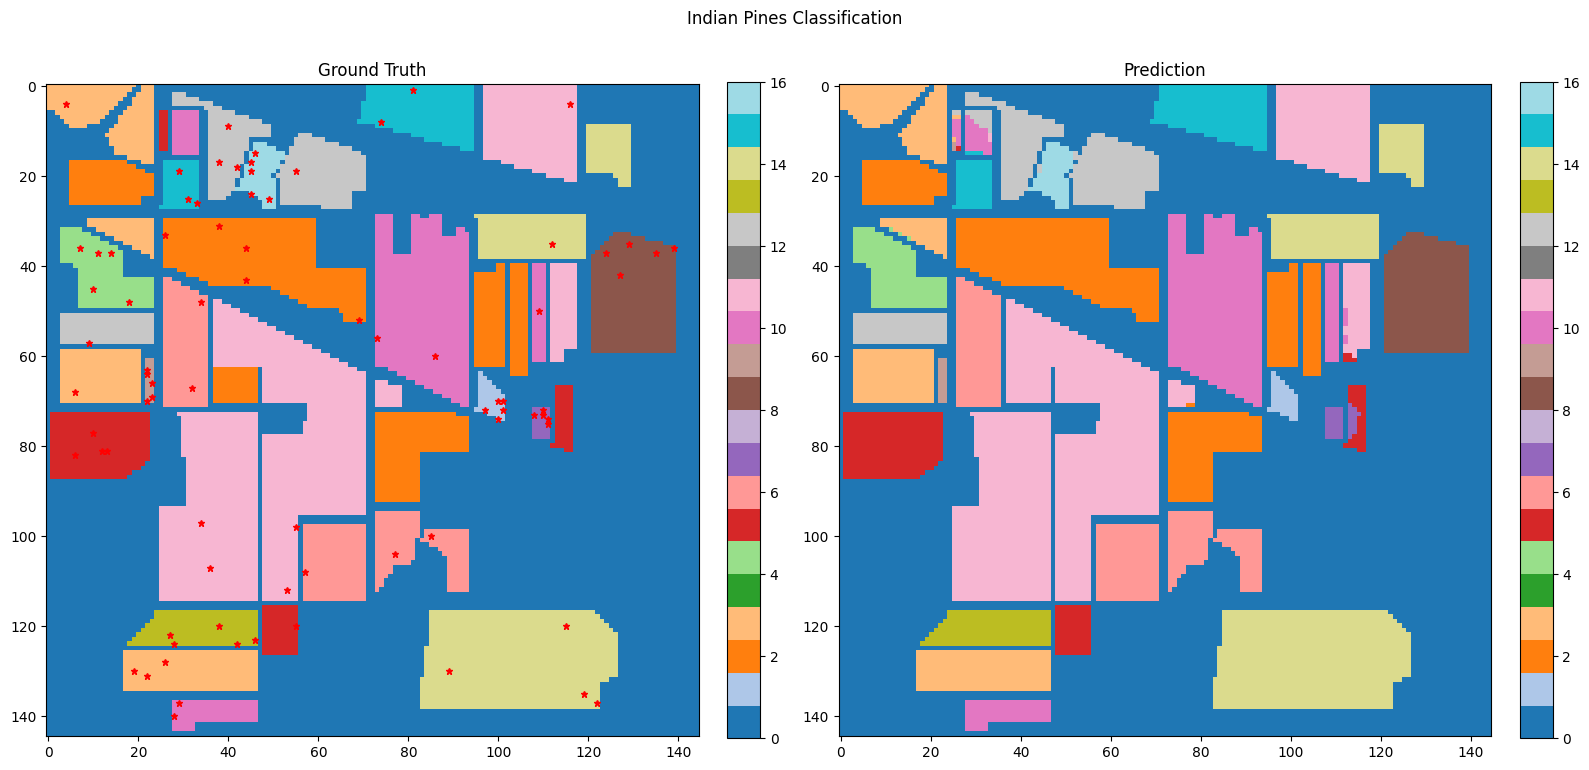

Final Overall Accuracy: 98.47%
Final Validation Accuracy: 32.41%
Final Kappa: 0.9825
Class-wise accuracies:
Class 1: Alfalfa: 100.00%
Class 2: Corn-notill: 94.40%
Class 3: Corn-mintill: 99.64%
Class 4: Corn: 100.00%
Class 5: Grass-pasture: 93.37%
Class 6: Grass-trees: 100.00%
Class 7: Grass-pasture-mowed: 100.00%
Class 8: Hay-windrowed: 100.00%
Class 9: Oats: 100.00%
Class 10: Soybean-notill: 97.43%
Class 11: Soybean-mintill: 99.47%
Class 12: Soybean-clean: 100.00%
Class 13: Wheat: 100.00%
Class 14: Woods: 100.00%
Class 15: Buildings-Grass-Trees-Drives: 100.00%
Class 16: Stone-Steel-Towers: 95.70%
Mean Class Accuracy: 98.75%


In [15]:
noises = ['Gaussian',]
OAs = {None:0, 'Gaussian':0, 'Poisson':0, 'SaltPepper':0, 'Speckle':0}
ValAs = {None:0, 'Gaussian':0, 'Poisson':0, 'SaltPepper':0, 'Speckle':0}
AAs = {None:0, 'Gaussian':0, 'Poisson':0, 'SaltPepper':0, 'Speckle':0}
kappas = {None:0, 'Gaussian':0, 'Poisson':0, 'SaltPepper':0, 'Speckle':0}
mean_all = {
    'OA' : [],
    'ValA' : [],
    'AA' : [],
    'Kappa' : []
}
all_hist_stats = {None:{}, 'Gaussian':{}, 'Poisson':{}, 'SaltPepper':{}, 'Speckle':{}}
for noise in noises:
    for i in range(42, 43):
        print(f"\nTraining with noise: {noise}, seed {i}")
        np.random.seed(i)
        torch.manual_seed(i)
        torch.cuda.manual_seed(i)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
        data, ground_truth, label_names = load_dataset(name='indian_pines')
        print(f"Data shape: {data.shape}")
        print(f"Ground truth shape: {ground_truth.shape}")
        print(f"Number of classes: {len(np.unique(ground_truth))-1}")  # -1 for background

        # Apply PCA for dimensionality reduction
        reduced_data = apply_pca(data, n_components=30)

        # Create few-shot samples (5 samples per class)
        few_shot_indices = create_few_shot_samples(ground_truth, k_shots=5)
        print(f"Number of few-shot samples: {len(few_shot_indices)}")

        # Number of classes (excluding background)
        num_classes = len(np.unique(ground_truth)) - 1

        # Train with progressive sample selection
        model, accuracies, kappa, errors, classification_map = train_with_progressive_selection(
            hsi_data=reduced_data,
            ground_truth=ground_truth,
            few_shot_indices=few_shot_indices,
            num_classes=num_classes,
            epochs=20,
            max_rounds=8,
            confidence_threshold=0.6,
            patch_size=13,
            embedding_dim=64,
            padding=1,
            region_threshold=100,
            noise=noise,
            verbose='Full no',
            device=device
        )
        all_hist_stats[noise][i] = {
            'OA': accuracies['all'],
            'ValA': accuracies['valid'],
            'Kappa': kappa['all'],
            'AA' : accuracies['class'],
        }

        # Save model
        model_path = f"models/multiscale_model_indian_pines_{noise}_seed_{i}.pth"
        torch.save(model.state_dict(), model_path)

        # Visualize results
        visualize_results(
            ground_truth=ground_truth,
            pred_map=classification_map,
            few_shot_indices=few_shot_indices,
            title=f"Indian Pines Classification"
        )

        print("Final Overall Accuracy: {:.2f}%".format(accuracies['all'][-1] * 100))
        print("Final Validation Accuracy: {:.2f}%".format(accuracies['valid'][-1] * 100))
        print("Final Kappa: {:.4f}".format(kappa['all'][-1]))

        OAs[noise] = accuracies['all'][-1] * 100
        ValAs[noise] = accuracies['valid'][-1] * 100
        kappas[noise] = kappa['all'][-1]
        
        # Class-wise accuracies
        all_accs = []
        print("Class-wise accuracies:")
        for i in range(num_classes):
            class_accuracy = np.sum((ground_truth == (i + 1)) & (classification_map == (i + 1))) / np.sum(ground_truth == (i + 1))
            all_accs.append(class_accuracy)
            print(f"Class {i+1}: {label_names[i + 1]}: {class_accuracy * 100:.2f}%")

        print(f"Mean Class Accuracy: {np.mean(all_accs) * 100:.2f}%")
        AAs[noise] = np.mean(all_accs) * 100

        mean_all['OA'].append(OAs[noise])
        mean_all['ValA'].append(ValAs[noise])
        mean_all['AA'].append(AAs[noise])
        mean_all['Kappa'].append(kappas[noise])

In [16]:
all_hist_stats[noise]

{42: {'OA': [0.6683578885744951,
   0.8051517221192311,
   0.8847692457800761,
   0.9270172699775587,
   0.9573616938237877,
   0.9691677236803591,
   0.9749243828666211,
   0.9846814323348619],
  'ValA': [0.19791912981792387,
   0.19285424279334146,
   0.10470779220779221,
   0.13559322033898305,
   0.24568965517241378,
   0.28213166144200624,
   0.25,
   0.32407407407407407],
  'Kappa': [0.6320281884101898,
   0.781503171276743,
   0.8695344794939907,
   0.9171378974079185,
   0.9514804933527288,
   0.9648850785957618,
   0.9714199195682353,
   0.9825256296947303],
  'AA': [0.8085885008966079,
   0.9012844573761394,
   0.9356198277256995,
   0.9561665978654956,
   0.972932309633633,
   0.9781008542786223,
   0.9820006291186261,
   0.9875052695146166]}}

In [17]:
mean_all

{'OA': [98.46814323348619],
 'ValA': [32.407407407407405],
 'AA': [98.75052695146167],
 'Kappa': [0.9825256296947303]}

In [18]:
for k,v in mean_all.items():
    if k == 'Kappa':
        print(f"Mean {k}: {np.mean(v):.4f}, standard deviation: {np.std(v):.4f}")
    else:
        print(f"Mean {k}: {np.mean(v):.2f}%, standard deviation: {np.std(v):.2f}%")

Mean OA: 98.47%, standard deviation: 0.00%
Mean ValA: 32.41%, standard deviation: 0.00%
Mean AA: 98.75%, standard deviation: 0.00%
Mean Kappa: 0.9825, standard deviation: 0.0000


In [19]:
#load model
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
model = HybridHSIClassifier(
    input_channels=30, num_classes=num_classes, embedding_dim=64, patch_size=13,
    num_heads=8, mlp_dim=16, padding=1, num_tokens=8, noise='Gaussian'
).to(device)
model.load_state_dict(torch.load("models/multiscale_model_indian_pines_Gaussian_seed_42.pth", weights_only=True))
model.eval()
#load data
data, ground_truth, label_names = load_dataset(name='indian_pines')
print(f"Data shape: {data.shape}")
print(f"Ground truth shape: {ground_truth.shape}")
print(f"Number of classes: {len(np.unique(ground_truth))-1}")  # -1 for background
# Apply PCA for dimensionality reduction
reduced_data = apply_pca(data, n_components=30)
# Create few-shot samples (5 samples per class)
few_shot_indices = create_few_shot_samples(ground_truth, k_shots=5)
# Number of classes (excluding background)
num_classes = len(np.unique(ground_truth)) - 1

# Create dataset for all valid pixels (gt > 0) for evaluation
valid_pixels_dataset = HSIDataset(data=reduced_data, labels=ground_truth, patch_size=13)


ps = ProgressivePseudoLabelSelection(
    model=model,
    device=device,
    num_classes=num_classes,
    confidence_threshold=0.6,
    region_threshold=100
)

# evaluate
test_loader = DataLoader(
    torch.utils.data.Subset(valid_pixels_dataset, list(range(len(valid_pixels_dataset)))), # Can simply use range for all test data
    batch_size=128,
    shuffle=False,
)
accuracy, kappa, _, _, _, _ = ps.evaluate(test_loader)
print(f"Overall accuracy: {accuracy*100:.2f}%")
print(f"Kappa: {kappa:.4f}")
# Class-wise accuracies
all_accs = []
print("Class-wise accuracies:")
for i in range(num_classes):
    class_accuracy = np.sum((ground_truth == (i + 1)) & (classification_map == (i + 1))) / np.sum(ground_truth == (i + 1))
    all_accs.append(class_accuracy)
    print(f"Class {i+1}: {label_names[i + 1]}: {class_accuracy * 100:.2f}%")

print(f"Mean Class Accuracy: {np.mean(all_accs) * 100:.2f}%")

Data shape: (145, 145, 200)
Ground truth shape: (145, 145)
Number of classes: 16
Applying PCA to reduce dimensions from 200 to 30...
Overall accuracy: 98.47%
Kappa: 0.9825
Class-wise accuracies:
Class 1: Alfalfa: 100.00%
Class 2: Corn-notill: 94.40%
Class 3: Corn-mintill: 99.64%
Class 4: Corn: 100.00%
Class 5: Grass-pasture: 93.37%
Class 6: Grass-trees: 100.00%
Class 7: Grass-pasture-mowed: 100.00%
Class 8: Hay-windrowed: 100.00%
Class 9: Oats: 100.00%
Class 10: Soybean-notill: 97.43%
Class 11: Soybean-mintill: 99.47%
Class 12: Soybean-clean: 100.00%
Class 13: Wheat: 100.00%
Class 14: Woods: 100.00%
Class 15: Buildings-Grass-Trees-Drives: 100.00%
Class 16: Stone-Steel-Towers: 95.70%
Mean Class Accuracy: 98.75%
